<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 2: Linear Discriminant Analysis Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Malawi Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#setup)  
[Scikit-Learn Linear Discriminant Analysis](#sklearn-lda)  
&nbsp;&nbsp;&nbsp;[Include All Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[GridSearchCV](#grid-search)  
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Linear Discriminant Analysis Classifier Introduction <a class="anchor" id="introduction"></a>

Linear discriminant analysis (LDA) is a discriminative supervised learning algorithm commonly used to reduce dimensionality in machine learning problems, which can help avoid overfitting and reduce computational costs. It can be used for binary and multi-class classification problems, often outperforming logisitic regression in the multi-class case. LDA finds a decision boundary by using the training data to construct a lower-dimensional space onto which the data is projected. The basis of this space is chosen such that the means of the two classes are maximally separated, while the variances are minimized.

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

**Assumptions and properties.** LDA makes important assumptions regarding the conditional density of the data. Specifically, LDA assumes that the conditional density $p(x\vert Y=y)$ is a normal (Gaussian) distribution. While the means of different classes may differ, their covariances are assumed to be equal (and of full rank, i.e., no features are redundant). In other words, we assume that $p(x\vert Y=y_0)$ ~ $N(\mu_0, \Sigma_0)$ and $p(x\vert Y=y_1)$ ~ $N(\mu_1, \Sigma_1)$ where $\Sigma_0 = \Sigma_1 = \Sigma$.

**Algorithm and Training.** Under the above assumptions, standard methods such as maximum likilihood as well as maximum a posteriori estimations of the class means and covariances can be obtained. With those quantities in hand, the data are projected onto a new space $w=\Sigma^{-1}(\mu_1 - \mu_0)$ that maximizes the separation between class means while minimizing variance between the two clusters. In this way, LDA maximizes separability among the known training categories.

For example, we take the same example data we presented in the Data Preparation notebook and apply LDA classification. Since this is a binary classification problem, the classifier will project the data onto a single dimension, where the distribution of each class is assumed to be normal with the same covariance but different means. This essentially gives us a linear decision boundary similar to what we had with the logistic regression classifier.

<img alt="LDA diagram" src="img/lda.png"/>

## Considerations <a class="anchor" id="introduction-considerations"></a>

* We can use LDA dimension reduction then check which variables correlate with the new axes the most to do feature selection
* It is recommended to standardize numeric data to mean of 0 and standard deviation of 1 to improve performance
* Removing outliers may improve performance
* Consider transformations for each variable to make their distribution more gaussian

# Data setup <a class="anchor" id="setup"></a>

First, load in the standard libraries as before. Note that we've placed some of the functions we developed in the Logistic Regression notebooks in the `process_features` module so we don't need to copy the code each time.

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))

from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

ALGORITHM_NAME = 'lda'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 484 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,5,3,0.0,1.0,3,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,3,2,1.0,3.0,1,1,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,6,5,0.0,2.0,3,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,3,3,3.0,3.0,1,1,1,3,1,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,2,1,0.0,2.0,0,1,1,2,0,0,...,1,0,0,1,0,0,0,0,0,0


# Scikit-Learn Linear Discriminant Analysis Model <a class="anchor" id="sklearn-lda"></a>

We'll build the basic model first with just a few features for simplicity. We stored the basic list of features we used previously in `MWI_BASIC_FEATURES` in the `process_features` module.

In [3]:
selected_columns = MWI_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 9)


In [4]:
# Same method for getting the coefficients as we used with Malawi
def get_coefs_df(X, coefs, index=None):
    coefs_df = pd.DataFrame(np.std(X, 0)*coefs)
    coefs_df.columns = ["coef_std"]
    coefs_df['coef'] = coefs
    coefs_df['abs'] = coefs_df.coef_std.apply(abs)
    if index is not None:
        coefs_df.index = index
    return coefs_df

One of the benefits of LDA is that there are no hyperparameters to tune, and we do not necessarily need to standardize the features as we did with the logistic regression classifier. However, standardization may still provide us a minor performance boost and is a good practice. LDA is also sensitive to multicollinearity, so we should attempt to remove highly collinear features if possible.

CPU times: user 7.55 ms, sys: 3.6 ms, total: 11.2 ms
Wall time: 9.06 ms
CPU times: user 90.6 ms, sys: 678 ms, total: 769 ms
Wall time: 37.4 ms
In-sample score: 75.80%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


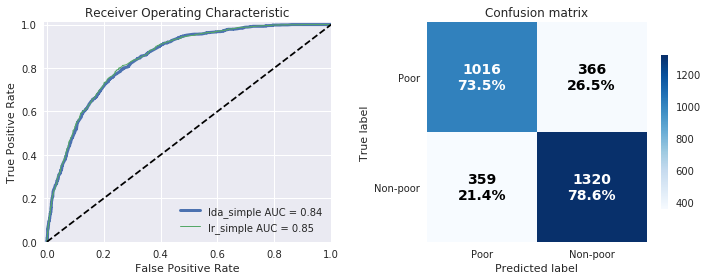

,lda_simple,lr_simple
accuracy,0.763149,0.766743
recall,0.735166,0.738784
precision,0.738909,0.743086
f1,0.737033,0.740929
cross_entropy,0.488056,0.478969
roc_auc,0.844833,0.847856
cohen_kappa,0.521582,0.528811


Actual poverty rate: 54.11% 
Predicted poverty rate: 58.77% 


In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=selected_columns)

# Fit the model
model = LinearDiscriminantAnalysis()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train[selected_columns], model.coef_[0])

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

This LDA model performs very similiarly compared to the simple logistic regression classifier we previously built.

To gain a better understanding of what is happening in this algorithm, we'll look at how the data is transformed. The LDA model attempts to find the optimal projection that provides the best separation of the classes. For n-classes, this means it will project the data onto at most an n-1 subspace. In the case of binary classification, we end up with a 1-dimensional subspace. 

Since LDA assumes a gaussian distribution of the classes with the same covariance matrix, we would expect to see the data as two normal distributions when we plot it in the transformed space. When we use this as a classifier, the model picks the class with the nearest mean to the data point. 

Below, we plot the transformed training data and the resulting distributions to demonstrate this.

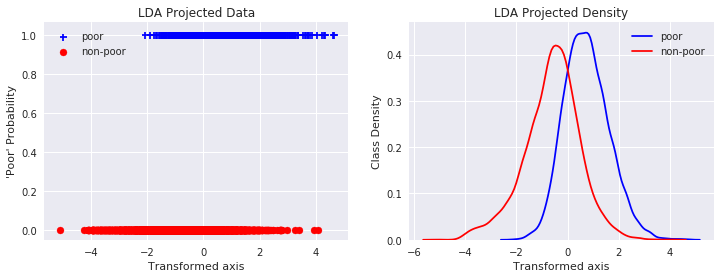

In [6]:
X_lda = model.transform(X_train)

mask = (y_train == 1)
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(X_lda[mask], y_train[mask], color='b', marker='+', label='poor')
axes[0].scatter(X_lda[~mask], y_train[~mask], color='r', marker='o', label='non-poor')
axes[0].set_title('LDA Projected Data')
axes[0].set_xlabel('Transformed axis')
axes[0].set_ylabel('\'Poor\' Probability')
axes[0].legend()

sns.kdeplot(np.ravel(X_lda[mask]), color='b', ax=axes[1], label='poor')
sns.kdeplot(np.ravel(X_lda[~mask]), color='r', ax=axes[1], label='non-poor')
axes[1].set_title('LDA Projected Density')
axes[1].set_xlabel('Transformed axis')
axes[1].set_ylabel('Class Density')
axes[1].legend()
plt.show()

## LDA with all features <a class="anchor" id="all-feats"></a>

Now let's apply the LDA classifier to the dataset with all features.

The Scikit-learn implementation of LDA does not have the option to use sample weights when we fit the model. However, we can apply the sample weights when scoring the model.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


CPU times: user 6.9 s, sys: 41.3 s, total: 48.2 s
Wall time: 2.64 s
CPU times: user 137 ms, sys: 1.18 s, total: 1.32 s
Wall time: 58.4 ms
In-sample score: 87.91%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


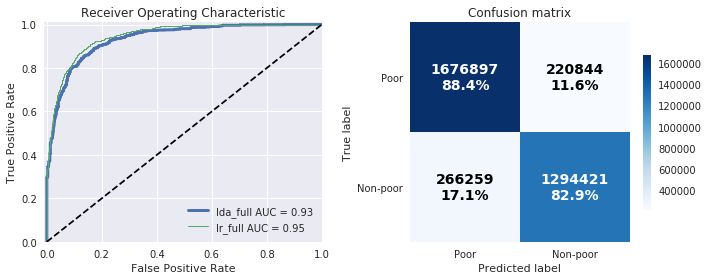

,lda_full,lr_full
accuracy,0.859154,0.873897
recall,0.883628,0.869754
precision,0.862976,0.853693
f1,0.87318,0.861649
cross_entropy,0.326524,0.288223
roc_auc,0.934298,0.948658
cohen_kappa,0.719414,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.58% 


In [7]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LinearDiscriminantAnalysis()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

Once again, the performance is very similar to our Logisitic Regression classifier with all the features. We'll plot the distributions below again as well. We should be able to observe more separation in the class distributions, which results in a higher classifier performance.

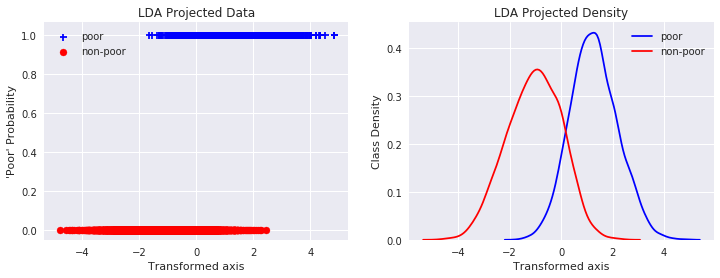

In [8]:
X_lda = model.transform(X_train)

mask = (y_train == 1)
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(X_lda[mask], y_train[mask], color='b', marker='+', label='poor')
axes[0].scatter(X_lda[~mask], y_train[~mask], color='r', marker='o', label='non-poor')
axes[0].set_title('LDA Projected Data')
axes[0].set_xlabel('Transformed axis')
axes[0].set_ylabel('\'Poor\' Probability')
axes[0].legend()

sns.kdeplot(np.ravel(X_lda[mask]), color='b', ax=axes[1], label='poor')
sns.kdeplot(np.ravel(X_lda[~mask]), color='r', ax=axes[1], label='non-poor')
axes[1].set_title('LDA Projected Density')
axes[1].set_xlabel('Transformed axis')
axes[1].set_ylabel('Class Density')
axes[1].legend()
plt.show()

## GridSearchCV <a class="anchor" id="grid-search"></a>

As with all of the models we will be building, it is good practice to apply cross validation to avoid overfitting the data. LDA in Scikit-Learn does not have a specific version that performs cross validation. There are, however, other useful modules within Scikit-Learn that are more generalized and allow us to apply this functionality to any classifier. One that we will be using throughout this project is [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). This function allows us to tune parameters and conduct cross validation simultaneously. 

When we build a model using this function, we will need to declare the estimator and parameter grid. In the case of LDA, we do not have any model parameters to tune, but there are options for different solvers to use, so we can test each of these out using GridSearchCV to find the one that gives us the best performance.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(

CPU times: user 25.7 s, sys: 2min 24s, total: 2min 50s
Wall time: 40.7 s
CPU times: user 72.9 ms, sys: 1.08 s, total: 1.16 s
Wall time: 476 ms
In-sample score: 88.35%
Best model parameters: {'solver': 'svd'}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


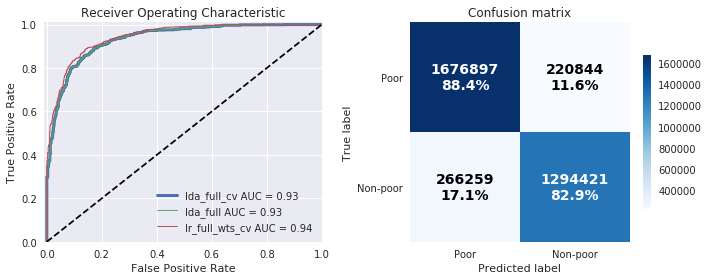

,lda_full_cv,lda_full,lr_full_wts_cv
accuracy,0.859154,0.859154,0.873458
recall,0.883628,0.883628,0.891581
precision,0.862976,0.862976,0.87947
f1,0.87318,0.87318,0.885484
cross_entropy,0.326524,0.326524,0.300498
roc_auc,0.934298,0.934298,0.944474
cohen_kappa,0.719414,0.719414,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.58% 


In [9]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# build the model
estimator = LinearDiscriminantAnalysis()
parameters = {'solver': ['svd']}

model = GridSearchCV(estimator, parameters, verbose=1, cv=5)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.best_estimator_.coef_[0])
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lda_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

# Feature selection using correlation with LDA axis <a class="anchor" id="feature-selection"></a>
There are a few ways we can use the results of the LDA classifier to select features. We can apply a similar method to what we did in the logistic regression notebook, where we iteratively eliminate features until we reach a threshold. For this process, we could either use the coefficients of the model, or calculate the correlation between each feature column and the transformed axis that the LDA model produces.

In [10]:
def get_corrs_df(X, model):
    """ For a given feature matrix and LDA model, return
        the correlation of the LDA transformation and
        each feature. Also return the absolute value of
        the correlation.
    """
    X_lda = (model.transform(X)
                  .flatten())
    
    # extract single value from 2x2 correlation matrix
    calc_corr = lambda col: np.corrcoef(col, X_lda)[0, 1]
    
    corrs = (X.apply(calc_corr, axis=0)
               .to_frame())
    corrs.columns = ['correlation']
    
    # add absolute value column
    corrs['abs'] = corrs.correlation.apply(abs)
    
    return corrs.sort_values('abs', ascending=False)

In [11]:
corrs = get_corrs_df(X_train, model.best_estimator_)
display(corrs.head(20))
feats = corrs.index.values

,correlation,abs
cons_0801__Yes,-0.552448,0.552448
cons_0901__Yes,-0.536951,0.536951
cons_0111__Yes,-0.514034,0.514034
cons_0106__Yes,-0.491562,0.491562
cons_0401__Yes,-0.484570,0.484570
cons_0501__Yes,-0.478226,0.478226
cons_0803__Yes,-0.476702,0.476702
hld_headsleep__Bed & mattress,-0.457525,0.457525
cons_1204__Yes,-0.452743,0.452743
hld_cooking__Collected firewood,0.447584,0.447584


We can eliminate the features with very low correlation, since we know they have little impact on the transformed axis. 

In [12]:
# initially filter out lowest features
X_train, y_train, w_train = load_data(TRAIN_PATH)
best_model = evaluation.load_model('lda_full_cv', COUNTRY)
corrs = get_corrs_df(X_train, best_model['model'])
feats = corrs[corrs['abs'] > 0.15].index.values

# load metrics from our best model
best_model_metrics = evaluation.load_model_metrics('lda_full_cv', COUNTRY)

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Iteratively drop features until the f1 score is beneath our threshold
max_score = 0
f1_score = 1
f1_scores = []
f1_threshold = best_model_metrics['f1'] * 0.98

while (f1_score > f1_threshold) & (X_train.shape[1] >= 1):
    # Fit the model
    estimator = LinearDiscriminantAnalysis()
    parameters = {'solver': ['svd']}
    model = GridSearchCV(estimator, parameters).fit(X_train, y_train)
    
    # Get feature correlations
    corrs = get_corrs_df(X_train, model)
    feats = corrs.sort_values('abs', ascending=False).index.values

    # Run the model
    y_pred = model.predict(X_test[X_train.columns])
    y_prob = model.predict_proba(X_test[X_train.columns])[:,1]

    # Evaluate performance
    metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test, show=False)
    
    # Compare f1 score to threshold
    f1_score = metrics['f1']
    if f1_score > max_score:
        max_score = f1_score
        best_feats = X_train.columns
    
    # Drop feature with lowest coefficient
    X_train.drop(feats[-1], axis=1, inplace=True)
    print("n: {}, f1: {}, lowest coef: {}".format(len(feats), metrics['f1'], feats[-1]))
display(corrs)
selected_feats = feats

n: 145, f1: 0.8634210174798453, lowest coef: cons_0811__Yes
n: 144, f1: 0.8632569601426278, lowest coef: cons_1328__Yes
n: 143, f1: 0.8627655808645253, lowest coef: hld_busin9__Yes
n: 142, f1: 0.8628438438053992, lowest coef: cons_0902__Yes
n: 141, f1: 0.8628438438053992, lowest coef: com_bus__Yes
n: 140, f1: 0.862514046431673, lowest coef: geo_district__Zomba City
n: 139, f1: 0.8627410472121939, lowest coef: hld_rubbish__Rubbish bin
n: 138, f1: 0.862514046431673, lowest coef: cons_1336__Yes
n: 137, f1: 0.8620537396516994, lowest coef: own_518__Yes
n: 136, f1: 0.8621641370793803, lowest coef: hld_toilet__None
n: 135, f1: 0.8621641370793803, lowest coef: cons_0912__Yes
n: 134, f1: 0.8589212879725342, lowest coef: hld_toiletshr__nan
n: 133, f1: 0.8593095488467432, lowest coef: geo_district__Mzuzu City
n: 132, f1: 0.8588489368347787, lowest coef: cons_1322__Yes
n: 131, f1: 0.8572573515348348, lowest coef: cons_1332__Yes
n: 130, f1: 0.8574358929136139, lowest coef: cons_0114__Yes
n: 129, f

,correlation,abs
cons_0801__Yes,-0.582525,0.582525
cons_0901__Yes,-0.566184,0.566184
cons_0111__Yes,-0.542019,0.542019
cons_0106__Yes,-0.518323,0.518323
cons_0401__Yes,-0.510951,0.510951
cons_0501__Yes,-0.504262,0.504262
cons_0803__Yes,-0.502655,0.502655
hld_headsleep__Bed & mattress,-0.482434,0.482434
cons_1204__Yes,-0.477392,0.477392
hld_cooking__Collected firewood,0.471951,0.471951


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.6s finished


CPU times: user 3.87 s, sys: 35.5 s, total: 39.4 s
Wall time: 10.2 s
CPU times: user 12 ms, sys: 96.3 ms, total: 108 ms
Wall time: 11.7 ms
In-sample score: 85.28%
Best model parameters: {'solver': 'svd'}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


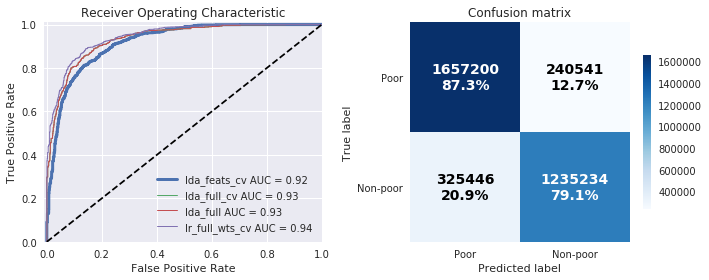

,lda_feats_cv,lda_full_cv,lda_full,lr_full_wts_cv
accuracy,0.836345,0.859154,0.859154,0.873458
recall,0.873249,0.883628,0.883628,0.891581
precision,0.835853,0.862976,0.862976,0.87947
f1,0.854142,0.87318,0.87318,0.885484
cross_entropy,0.356921,0.326524,0.326524,0.300498
roc_auc,0.918666,0.934298,0.934298,0.944474
cohen_kappa,0.667693,0.719414,0.719414,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 57.62% 


In [13]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=selected_feats)

# build the model
estimator = LinearDiscriminantAnalysis()
parameters = {'solver': ['svd', 'lsqr']}

model = GridSearchCV(estimator, parameters, verbose=1, cv=5)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.best_estimator_.coef_[0])
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=selected_feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lda_full_cv', 
                                                    'lda_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='feats_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=coefs)

In [14]:
feats = coefs.sort_values('abs', ascending=False).index.values
cons_feats = [x.split('__')[0] for x in feats if x.startswith('cons_')]
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(questions[x])

50 consumables features selected:
Chicken
Sugar
Goat
Tea
Public transport - Bus/Minibus
Banana
Rice
Eggs
Maize ufa refined (fine flour)
Margarine - Blue band
Buns, scones
Cassava tubers
Cooking oil
Beef
Bread
Donation - to church, charity, beggar, etc.
Other personal products (shampoo, razor blades, cosmetics, hair products, etc.)
Bean, brown
Toothpaste, toothbrush
Fresh fish
Toilet paper
Mandazi, doughnut (vendor)
Men's trousers
Charcoal
Newspapers or magazines
Tomato
Cleaning utensils (brooms, brushes, etc.)
Irish potato
Lady's dress/skirt
Chips (vendor)
Carpet, rugs, drapes, curtains
Chitenje cloth
Lady's shoes
Glycerine, Vaseline, skin creams
Men's shoes
Candles
Squash (Sobo drink concentrate)
Fresh milk
Biscuits
Tanaposi/Rape
Grass for thatching roof or other use
Clothes soap (powder)
Onion
Powdered milk
Soft drinks (Coca-cola, Fanta, Sprite, etc.)
Light bulbs
Men's shirts
Lady's blouse/shirt
Cabbage
Linen - towels, sheets, blankets


Using this feature selection process, we're able to get down to 50 consumable features. They appear to be similar in priority to our selected features from logistic regression, with meats such as chicken and goat near the top. Nearly all of these have a negative correlation with the LDA projected axis, which means that households that respond 'yes' to these questions are less likely to be poor. 

# LDA Malawi Summary <a class="anchor" id="summary"></a>



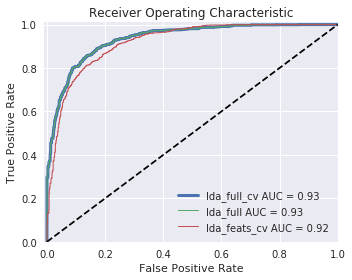

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
lda_full_cv,0.859154,0.883628,0.862976,0.87318,0.326524,0.934298,0.719414,0.0147335
lda_full,0.859154,0.883628,0.862976,0.87318,0.326524,0.934298,0.719414,0.0147335
lda_feats_cv,0.836345,0.873249,0.835853,0.854142,0.356921,0.918666,0.667693,0.0351301


In [15]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)